# Generic case

In this tutorial, we demonstrate how to perform total mRNA-aware analysis with `TOMAS` using **a generic scRNA-seq dataset that contains multiple cell types and unknown cell type labels**.

To illustrate the concept, we utilized a simulation dataset with known ground truth. In this simulation scenario, we generated four cell types with mRNA ratios set to 1:2:4:6. The Dirichlet-Multinomial probability signatures of these four cell types were derived from a human PBMC dataset. This example dataset is available for [download](https://github.com/QiuyuLian/TOMAS/datasets). 

In [16]:
import scanpy as sc
import pandas as pd
import numpy as np
import tomas as tm
import subprocess
import seaborn as sns

print(tm.__version__)

sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=60, facecolor='white')
sns.set_style("ticks")

0.1.25


In [2]:
adata = sc.read_h5ad('../../datasets/adata_mRNAonly.h5ad')
adata.obs.head(3)  # ground truth of droplet labels and total-mRNA ratios are stroed in adata.obs

,danno,trueR
d_5120,A,NaN
d_5201,A,NaN
d_5156,A,NaN


## Computational doublet detection

Here we use `R` package [DoubletFinder](https://github.com/chris-mcginnis-ucsf/DoubletFinder) for doublet detection. For the sake of compatibility, we demonstrate here the process of running `DoubletFinder` directly in Python using the `subprocess` module, and retrieving the identified doublet results for `TOMAS`.

The main function for computational dobulet identification is not included in `TOMAS`. Please download the R script [runDblFinder.R](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/doublet-detection.R) first and call it by `subprocess.call` like below. (Or you could also run `DoubletFinder` commands in R following its [tutorial](https://github.com/chris-mcginnis-ucsf/DoubletFinder) and save the results for `TOMAS`.) Please note that the R package `Seurat` is required as it is a dependancy for `DoubletFinder`. 

Three input arguments include the path of data stored in mtx format, the doublet rate and the ouput path. 

If available, the 'mtx_path' could be set as the path to the 'filtered_feature_bc_matrix' folder in standard output of CellRanger.

In [6]:
mtx_path = './data_mtx' 
tm.auxi.write_h5ad_to_mtx(adata,adata.obs_names,adata.var_names,mtx_path) # write .h5ad file to mtx file

We suggest using a **moderately high doublet rate** to run `DoubletFinder`.

In [4]:
doubletrate = 0.15
dblFinder_out = './dbl'

To maintain the cleanliness and readability of the tutorial, we have cleared the output of this command.

In [7]:
subprocess.call(['Rscript', 'runDblFinder.R', mtx_path, dblFinder_out, str(doubletrate)])

Attaching SeuratObject
Warning message:
package ‘Seurat’ was built under R version 4.0.5 


[1] "Data loaded."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  g-1190, g-12051, g-1191, g-1189, g-9572, g-16683, g-10027, g-18099, g-5249, g-6054 
	   g-1328, g-13246, g-18713, g-3834, g-6056, g-18717, g-1385, g-7139, g-18924, g-1142 
	   g-17750, g-17266, g-7723, g-10990, g-5497, g-10065, g-17058, g-1193, g-13344, g-7150 
Negative

[1] "Pre-process of Seurat object is done."


Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:Matrix’:

    det

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: viridis
Loading required package: viridisLite

Try help(fields) to get started.


[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix


[1] "Scaling data..."


  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix


[1] "Scaling data..."


  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Warning message:
package ‘spam’ was built under R version 4.0.5 
Loading required package: KernSmooth
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009
Loading required package: ROCR


NULL
[1] 0.01
[1] "pK identification is done!"
[1] "Creating 2667 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "All done!"


0

Read the output and save it in `adata.obs`.

In [8]:
dblFinder = pd.read_csv(dblFinder_out+'/DoubletFinder_out.csv', header=0, index_col=0)
pdbl_barcodes = dblFinder.index[dblFinder.iloc[:,-1]=='Doublet'].values.tolist()

adata.obs['dblFinder'] = 'Others'
adata.obs.loc[dblFinder.index,'dblFinder'] = dblFinder.iloc[:,-1].values
# match the terminologies used in TOMAS 
dbl2tomas = dict(zip(['Doublet','Singlet','unknown'],['Heterotypic','Homotypic','unknown'])) 
adata.obs['droplet_type'] = [dbl2tomas[f] for f in adata.obs['dblFinder']]

## Homotypic droplet population identification

Perform clustering on homotypic droplets.

In [9]:
adata_psgl = adata[adata.obs['droplet_type']=='Homotypic'].copy()
sc.pp.filter_cells(adata_psgl, min_genes=1)
sc.pp.filter_genes(adata_psgl, min_cells=1)
sc.pp.log1p(adata_psgl)
sc.pp.highly_variable_genes(adata_psgl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_psgl.raw = adata_psgl
adata_psgl = adata_psgl[:, adata_psgl.var.highly_variable]
sc.pp.scale(adata_psgl, max_value=10)
sc.tl.pca(adata_psgl, svd_solver='arpack')
sc.pp.neighbors(adata_psgl, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_psgl)

filtered out 2460 genes that are detected in less than 1 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:50)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


Please adjust the `resolution` parameter based on the results to avoid significant over-subdivision or under-subdivision.

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


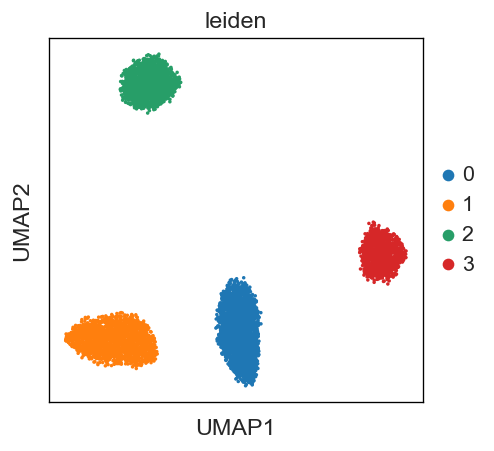

In [10]:
sc.tl.leiden(adata_psgl, resolution=0.1)
sc.pl.umap(adata_psgl, color=['leiden'])

(optional) In real case, you could first annotate the clusters with known cell-type markers before moving on. Here, as an example, we directly apply `TOMAS` to those clusters to showcase how to infer total-mRNA ratios with only scRNA-seq data.

Save identified cell cluters/types in `adata.obs` and perform DE analysis.

In [11]:
adata.obs['danno_RNAonly'] = 'unknown'
adata.obs.loc[adata_psgl.obs_names,'danno_RNAonly'] = adata_psgl.obs['leiden'].values
sc.tl.rank_genes_groups(adata_psgl, 'leiden', method='wilcoxon')
degene_sorted = tm.auxi.extract_specific_genes(adata_psgl, 'leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


## Hetero-doublets identification and refinement 

Identify hetero-dbls based on co-expression of marker genes of two cell types.

The naming convention of hetero-doublets is to use an underscore to connect the names of two constitutive cell types/clusters. (Underscore is not allowed in naming convention of pure cell types/clusters.)

Identify hetero-dbls composed by cluster '0' and cluster '1'

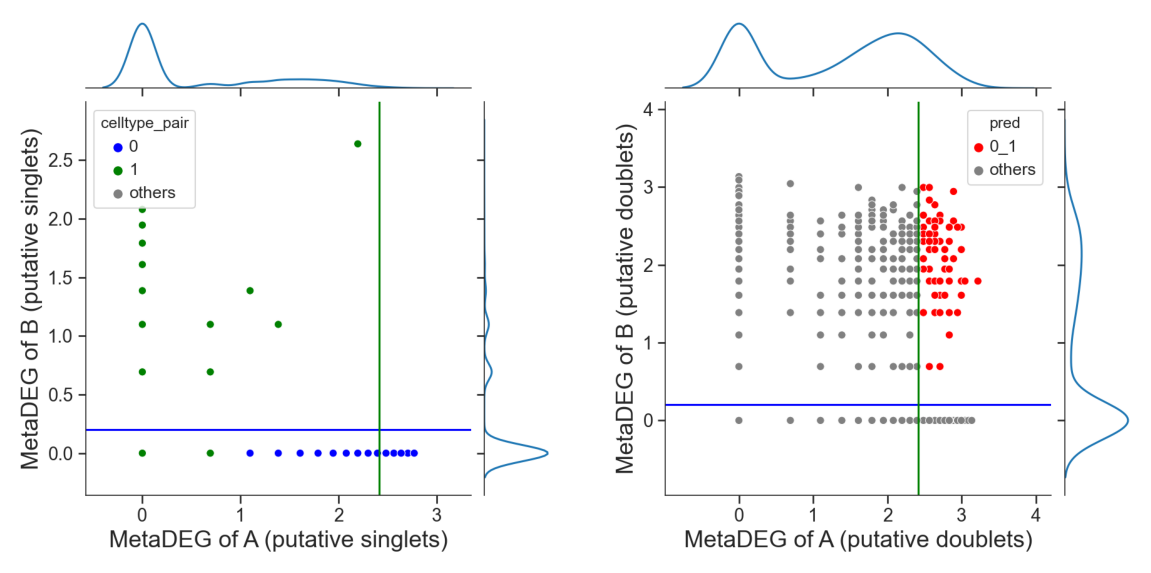

In [17]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_1',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

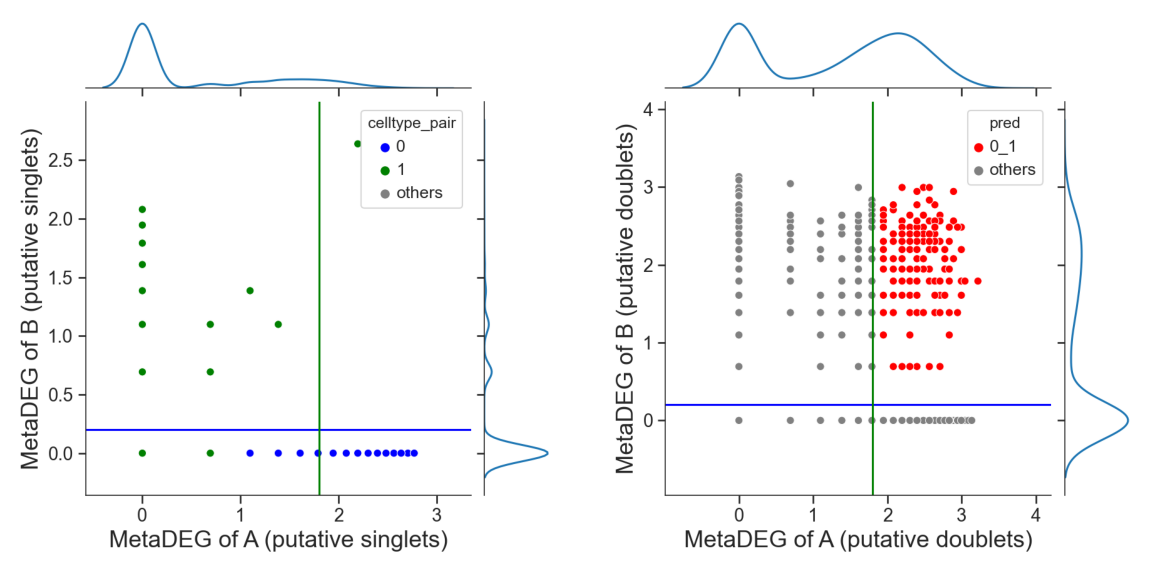

In [18]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '0_1',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_x = 1.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '0' and cluster '2'

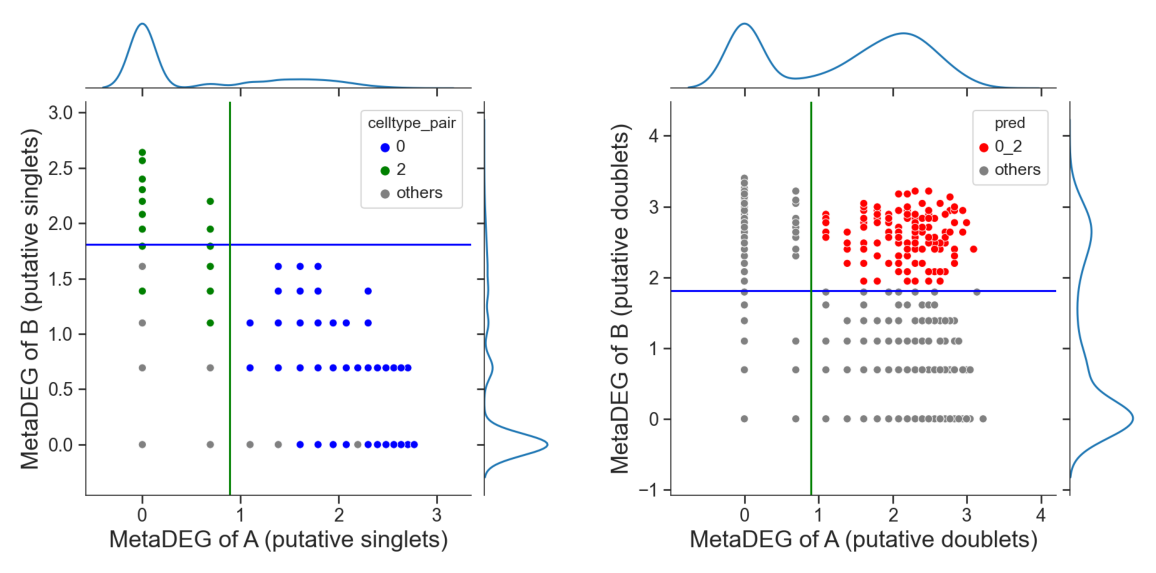

In [19]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_2',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '0' and cluster '3'

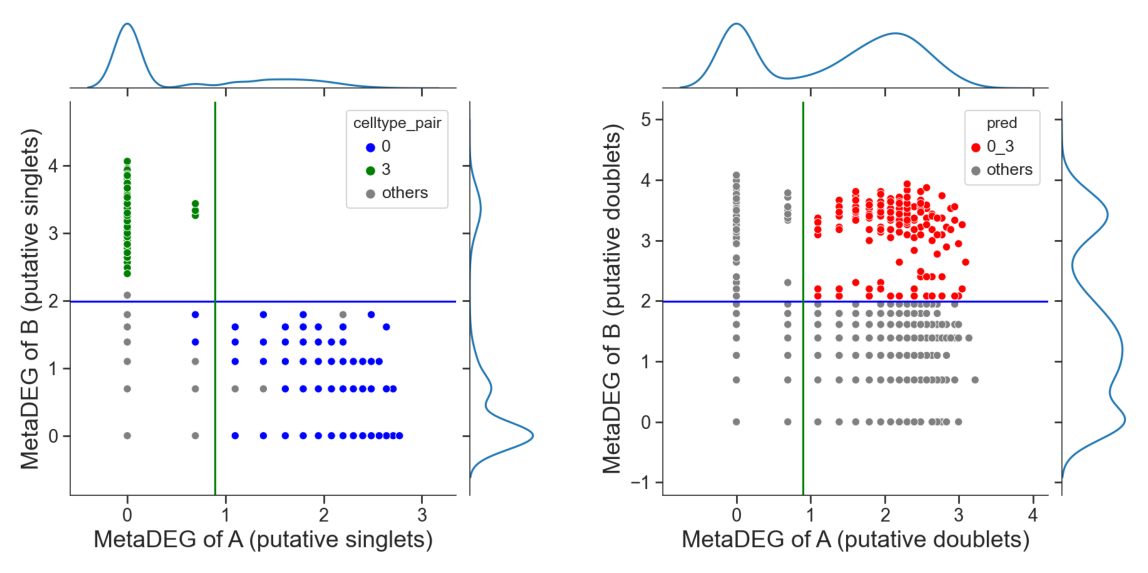

In [20]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

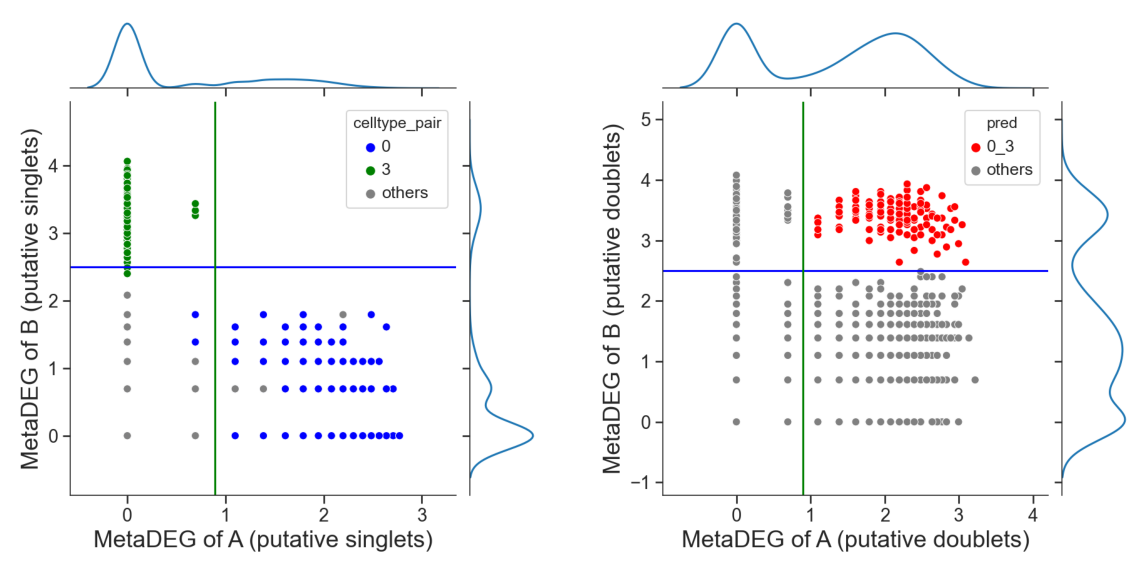

In [21]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '0_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.5,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '1' and cluster '2'

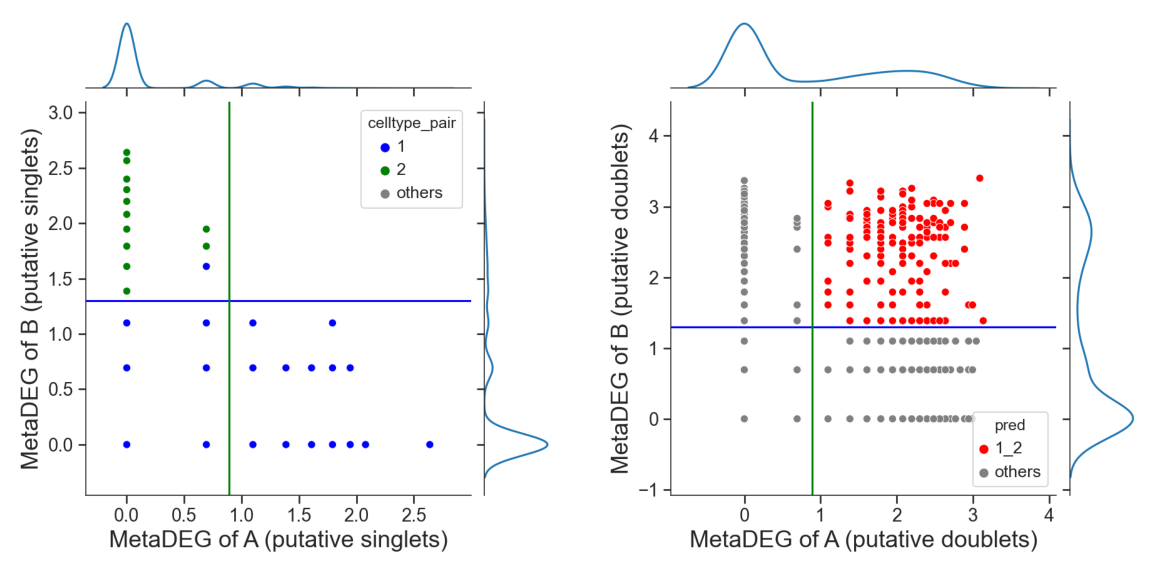

In [22]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '1_2',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '1' and cluster '3'

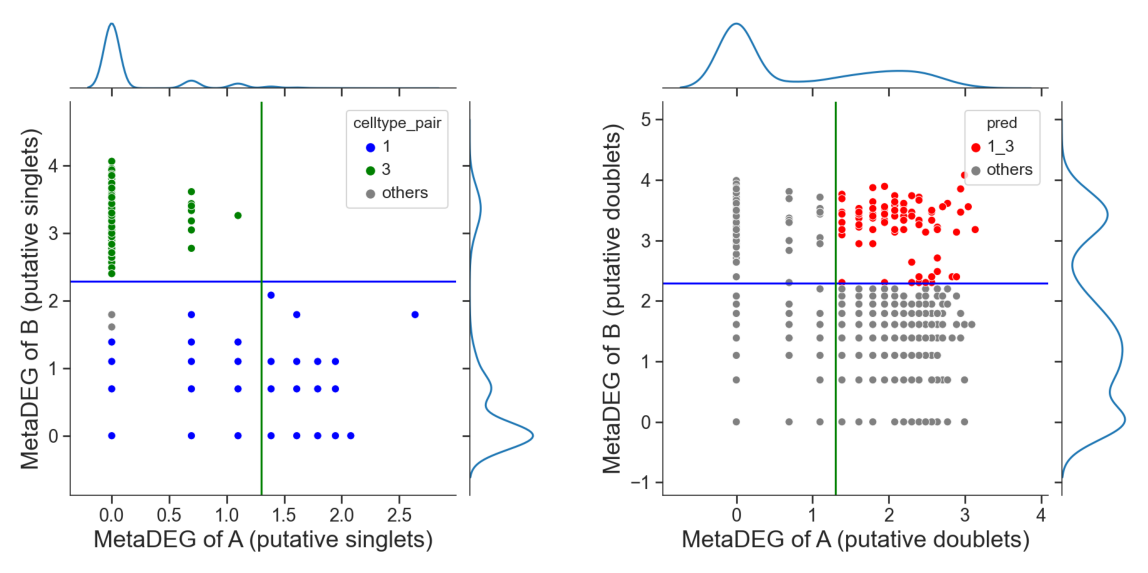

In [23]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '1_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

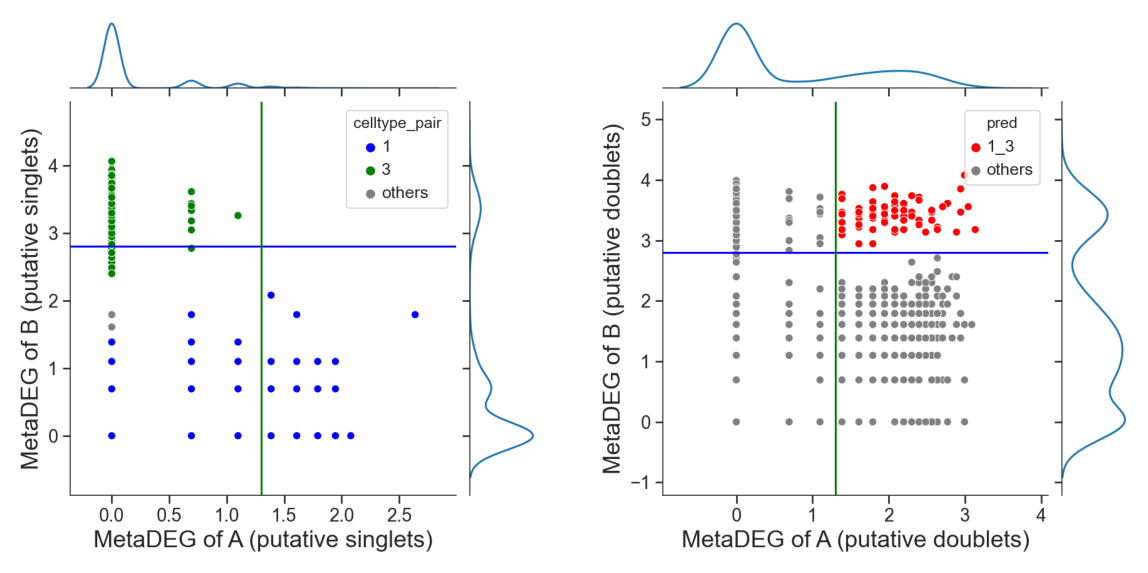

In [24]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '1_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '2' and cluster '3'

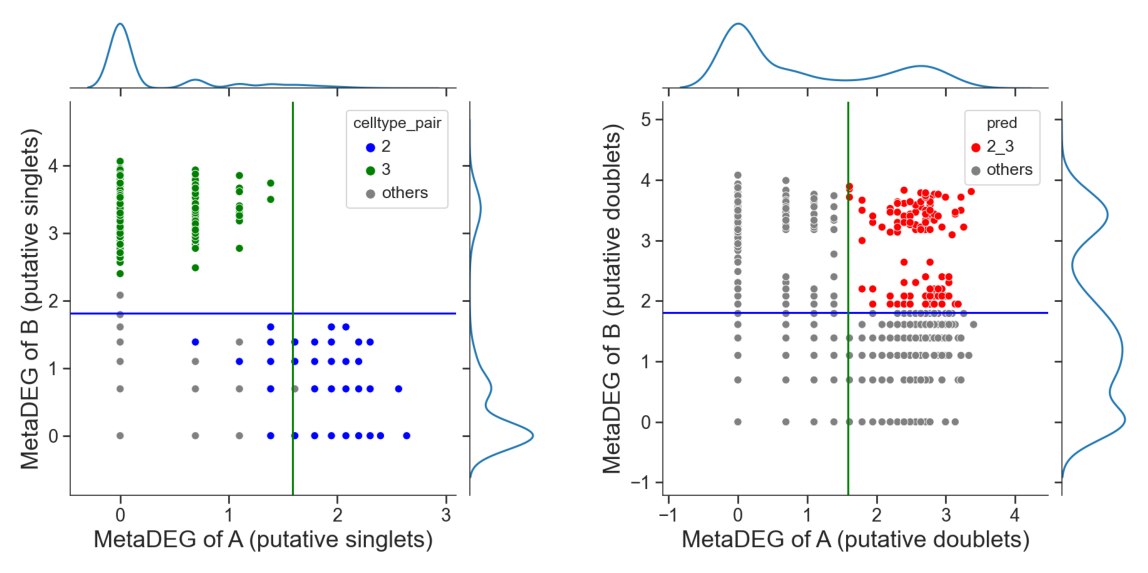

In [25]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '2_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

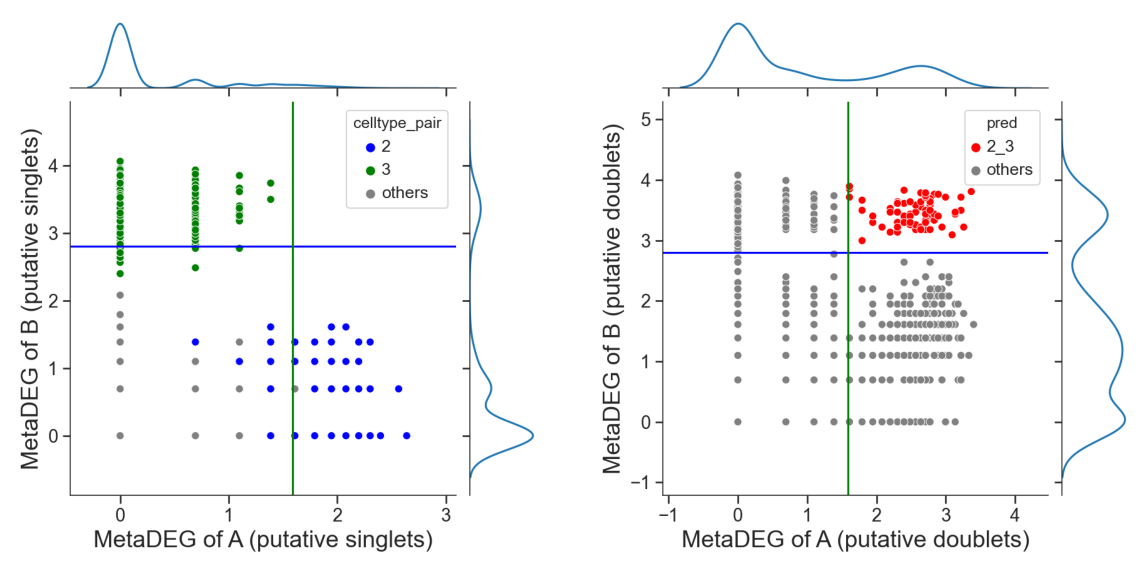

In [26]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '2_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Summarize droplet populations

In [27]:
tm.infer.heterodbl_summary(adata,ct_groupby='danno_RNAonly')

Counts of each kind of droplets:
        Hetero-dbl-type  counts
0                     0    2443
0_1                 0_1     159
0_2                 0_2     141
1                     1    1892
2                     2    1371
2_1                 2_1     120
3                     3    1094
3_0                 3_0     125
3_1                 3_1      65
3_2                 3_2      69
unknown         unknown     521


## Fit signature distribution for each cell type

In [35]:
tm.fit.logNormal(adata,groupby='danno_RNAonly')

tm.fit.dmn(adata,
           groupby='danno_RNAonly',
           groups=['0','1','2','3'],
           verbose=2,
           verbose_interval = 100)

Initialization 0
  Iteration 100	 time lapse 27.99422s	 ll change 0.01474
Initialization converged: True	 time lapse 53.12069s	 ll -22083.59051
3 is done!
Initialization 0
  Iteration 100	 time lapse 63.90034s	 ll change 0.03337
  Iteration 200	 time lapse 46.78527s	 ll change 0.00225
Initialization converged: True	 time lapse 128.20691s	 ll -22659.08424
1 is done!
Initialization 0
Initialization converged: True	 time lapse 64.72388s	 ll -20824.03802
0 is done!
Initialization 0
  Iteration 100	 time lapse 48.31856s	 ll change 0.06491
  Iteration 200	 time lapse 39.12279s	 ll change 0.00822
  Iteration 300	 time lapse 35.62597s	 ll change 0.00205
Initialization converged: True	 time lapse 144.18450s	 ll -20376.31360
2 is done!


In [36]:
adata_mgdic = tm.infer.get_dbl_mg(adata, groupby = 'danno_RNAonly') 

3_0
Initialized.
Iteration 2	time lapse 6.538322925567627s	ll change 961.1278374218382

Iteration 4	time lapse 6.737674951553345s	ll change 2.5695445142046083

Iteration 6	time lapse 6.617856025695801s	ll change 0.0553516095969826

Iteration 8	time lapse 6.618759870529175s	ll change 0.2357461184146814



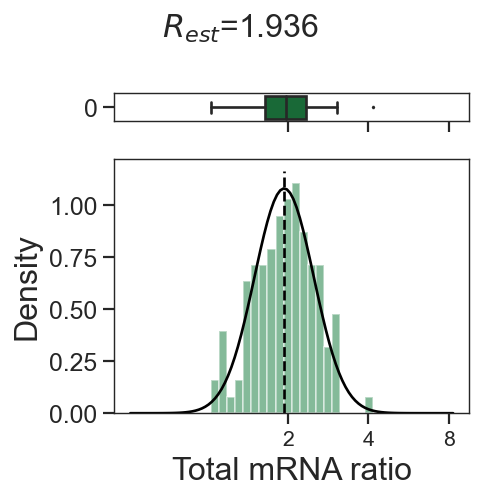

3_2
Initialized.
Iteration 2	time lapse 3.608137845993042s	ll change 605.7965120829613

Iteration 4	time lapse 3.6404342651367188s	ll change 0.5251441868604161

Iteration 6	time lapse 3.7944321632385254s	ll change 0.04800073504156899

Iteration 8	time lapse 3.7600269317626953s	ll change 0.008854479834553786

Iteration 10	time lapse 3.621471881866455s	ll change 0.003927798956283368

Iteration 12	time lapse 3.609372854232788s	ll change 0.0015178701432887465



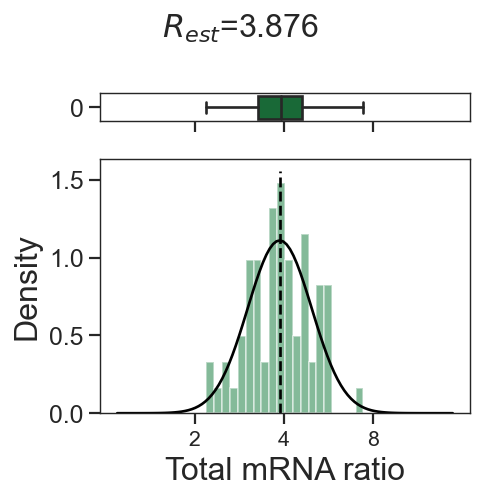

3_1
Initialized.
Iteration 2	time lapse 3.476285934448242s	ll change 1048.722740946745

Iteration 4	time lapse 3.4562551975250244s	ll change 3.0341219792317133

Iteration 6	time lapse 3.4567339420318604s	ll change 0.033150923321954906

Iteration 8	time lapse 3.421520948410034s	ll change 0.2048973583150655

Iteration 10	time lapse 3.4699621200561523s	ll change 0.23286737001035362

Iteration 12	time lapse 3.419652223587036s	ll change 0.015958367031998932

Iteration 14	time lapse 3.3813090324401855s	ll change 0.019465815072180703

Iteration 16	time lapse 3.4917490482330322s	ll change 0.0005136997497174889



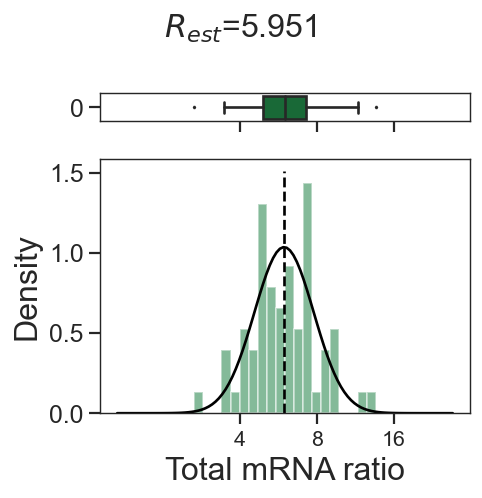

0_2
Initialized.
Iteration 2	time lapse 7.633837938308716s	ll change 2985.3777126442

Iteration 4	time lapse 7.419247150421143s	ll change 0.7131227364006918

Iteration 6	time lapse 7.4336018562316895s	ll change 0.44084842182928696

Iteration 8	time lapse 7.365525960922241s	ll change 0.054884115321328864

Iteration 10	time lapse 7.4306769371032715s	ll change 0.3013272018870339

Iteration 12	time lapse 7.570683717727661s	ll change 0.0067649108823388815

Iteration 14	time lapse 7.309781074523926s	ll change 0.005583436373854056

Iteration 16	time lapse 7.340006351470947s	ll change 0.005915446497965604

Iteration 18	time lapse 7.35421895980835s	ll change 0.0005001345125492662



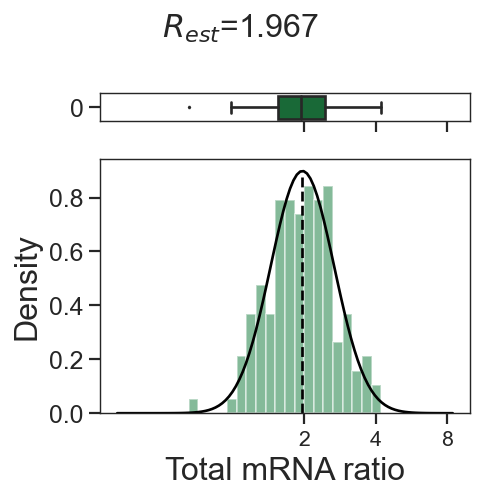

0_1
Initialized.
Iteration 2	time lapse 8.225429058074951s	ll change 4193.579104526492

Iteration 4	time lapse 8.216629981994629s	ll change 2.0725140407157596

Iteration 6	time lapse 8.300826787948608s	ll change 1.7412972433958203

Iteration 8	time lapse 8.239067792892456s	ll change 0.17068841357831843

Iteration 10	time lapse 8.243088006973267s	ll change 25.48961773159681

Iteration 12	time lapse 8.208273887634277s	ll change 0.001501033315435052



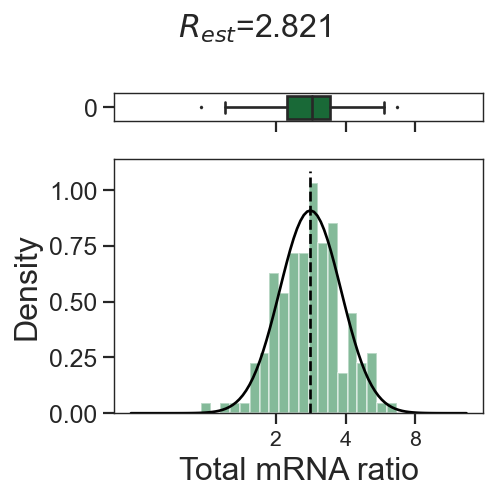

2_1
Initialized.
Iteration 2	time lapse 6.202265024185181s	ll change 7949.302253177593

Iteration 4	time lapse 6.16940712928772s	ll change 16.780481295660138

Iteration 6	time lapse 6.183964967727661s	ll change 1.7981202211522032

Iteration 8	time lapse 6.235758066177368s	ll change 0.15172424900811166

Iteration 10	time lapse 6.280344009399414s	ll change 0.510340300592361

Iteration 12	time lapse 6.186060190200806s	ll change 0.008658553706482053

Iteration 14	time lapse 6.186486005783081s	ll change 0.0254004942253232



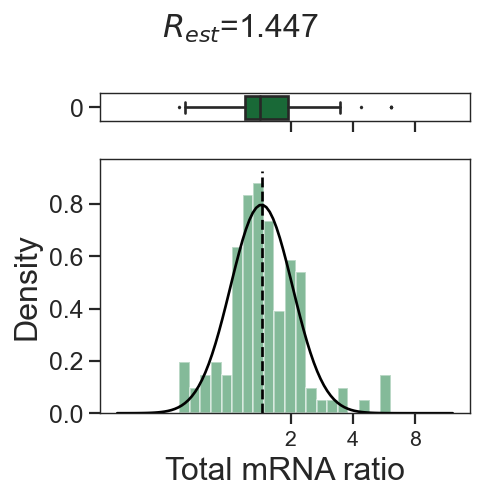

In [37]:
for dbl in adata_mgdic:
    print(dbl)
    
    tm.infer.ratios_bc(adata_mgdic[dbl],dbl,verbose=1)
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    tm.vis.logRatio_dist((1-w_best)/w_best)

## Compare with simulation ground truth

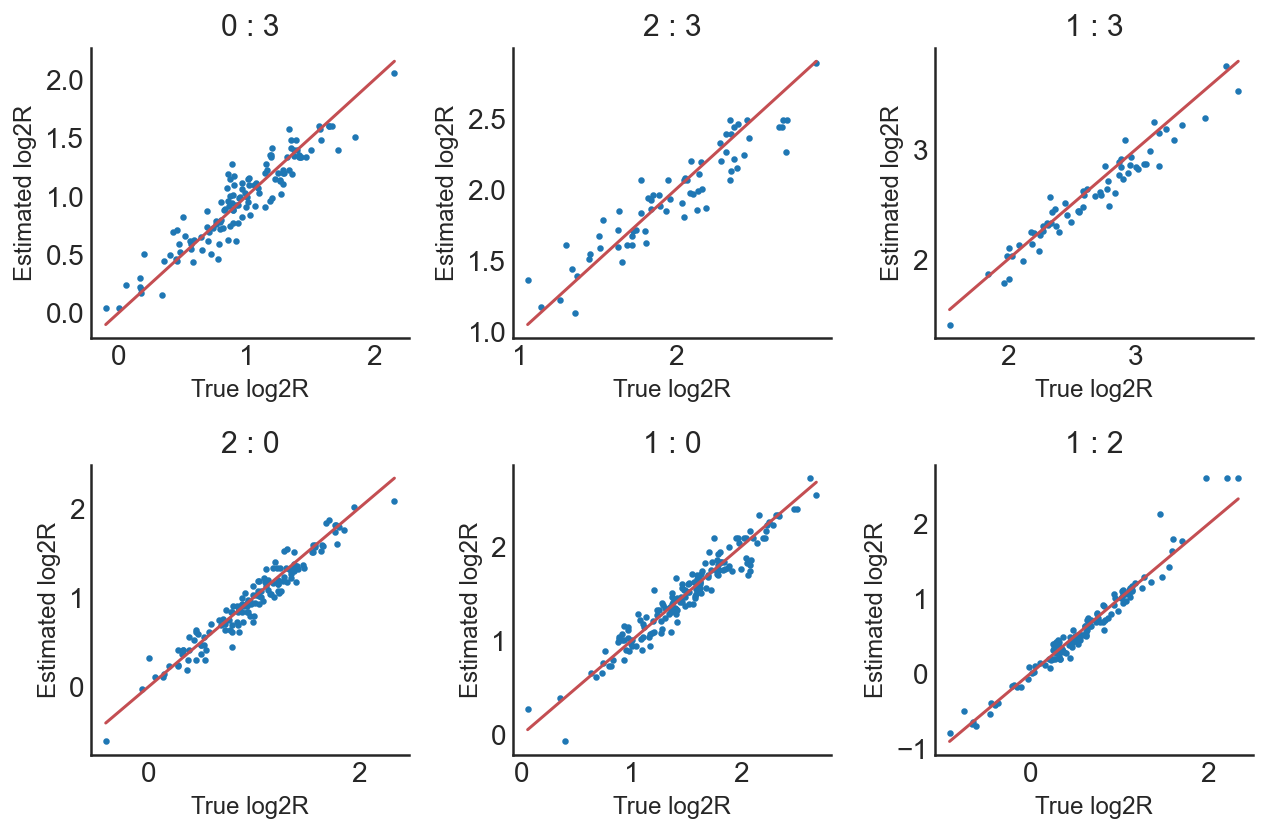

In [49]:
from matplotlib import pyplot as plt

dbl_groups = list(adata_mgdic.keys())

plt.figure(figsize=(9,3*np.ceil(len(dbl_groups) / 3)), dpi=72)
for i in range(len(dbl_groups)):
    ax = plt.subplot(int(np.ceil(len(dbl_groups)/3)),3,i+1)
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['danno_RNAonly']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)

    plt.scatter(log2R_true, log2R_pred,s=5)
    plt.plot([np.min(log2R_true),np.max(log2R_true)],[np.min(log2R_true),np.max(log2R_true)],c='r')

    plt.xlabel('True log2R',fontsize=12)
    plt.ylabel('Estimated log2R',fontsize=12)
    plt.title(dbl.split('_')[1]+' : '+dbl.split('_')[0],fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()

In [172]:
tm.infer.save_ratio_in_anndata(adata_mgdic, adata)

In [174]:
adata.write('./adata_tmp.h5ad')

In [171]:
import math
import statsmodels.api as sm

def save_ratio_in_anndata(adata_mgdic, adata, weight=True):
    
    adata.uns['ratio'] = {}
    for dbl in adata_mgdic:
        adata.uns['ratio'][dbl] = adata_mgdic[dbl].uns['ratio']
    
    r_df,r_serial = harmonize_ratios(adata_mgdic,weight=weight)
    adata.uns['ratio_summary'] = r_df
    adata.uns['ratio_serial'] = r_serial
    
    
def harmonize_ratios(adata_mgdic,weight=True):

    dbl_groups = list(adata_mgdic.keys())
    sgl_groups = list(np.unique([d for term in dbl_groups for d in term.split('_')]))

    r_info = pd.DataFrame(np.zeros([len(dbl_groups), len(sgl_groups)]),columns=sgl_groups)

    #print('Ratios estimated from each kind of heterodbls:')
    y_list = []
    for idx,dbl in enumerate(dbl_groups):
        c1,c2 = dbl.split('_')
        r_info.loc[idx, c1] = -1
        r_info.loc[idx, c2] = 1
        r_tmp = adata_mgdic[dbl].uns['ratio']['R_est']
        y_list.append(np.log2(r_tmp))
        #print(c2,':',c1,'=',r_tmp)

    X = r_info.values
    y = np.array(y_list)
    
    if weight:
        mod_wls = sm.WLS(y, X, weights=np.array([adata_mgdic[a].n_obs for a in adata_mgdic]))
    else:
        mod_wls = sm.WLS(y, X, weights=np.array([1]*len(adata_mgdic)))
    res_wls = mod_wls.fit()
    # print(res_wls.summary())

    pred_ols = res_wls.get_prediction()
    # pred_ols.summary_frame()
    
    #print('\nAfter regression:')
    r_corrected = 2**pred_ols.summary_frame()['mean']
    for idx,dbl in enumerate(dbl_groups):
        c1,c2 = dbl.split('_')
        #print(c2,':',c1,'=',r_corrected[idx])

    r_raw = []
    for dbl in dbl_groups:
        logUMI_para = adata_mgdic[dbl].uns['para_logUMI']
        c1,c2 = dbl.split('_')
        r = 2**(logUMI_para.loc[c2,'mean'] - logUMI_para.loc[c1,'mean'])
        r_raw.append(r)

    r_df = pd.DataFrame({'Ratio_rawUMI':r_raw,
                         'Ratio_estimated':[adata_mgdic[d].uns['ratio']['R_est'] for d in dbl_groups],
                         'Ratio_harmonized':r_adj.values
                        },index=[dbl.split('_')[1]+':'+dbl.split('_')[0] for dbl in dbl_groups])
    
    r_mat = pd.DataFrame(np.ones([len(sgl_groups),len(sgl_groups)]),index=sgl_groups,columns=sgl_groups)
    for pair in r_df.index:
        c1,c2 = pair.split(':')
        r_mat.loc[c1,c2] = r_df.loc[pair,'Ratio_harmonized']
        r_mat.loc[c2,c1] = 1/r_df.loc[pair,'Ratio_harmonized']

    sgl_reference = r_mat.columns[r_mat.apply(lambda col: sum(col>=1)==len(col),axis=0)]
    r_serial = pd.DataFrame(r_mat.loc[:,sgl_reference[0]].sort_values())
    
    return r_df,r_serial



In [177]:
import os
import matplotlib.image as mpimg


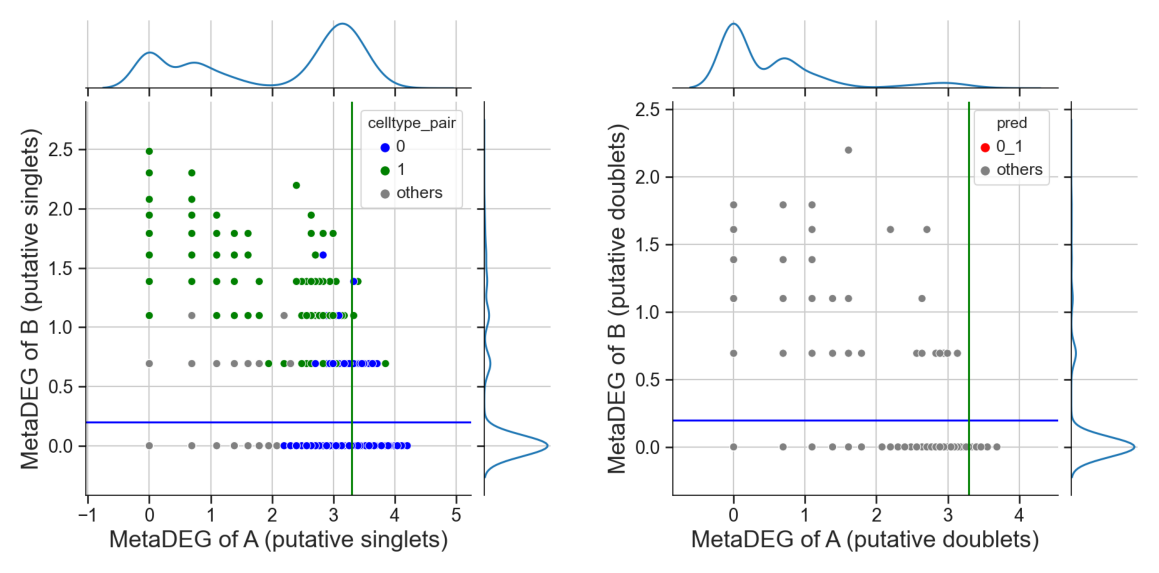

In [178]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5),dpi=60)
axarr[0].imshow(mpimg.imread('g1.png'))
axarr[1].imshow(mpimg.imread('g2.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

os.remove('g1.png')
os.remove('g2.png')